### find DRO solutions by minimization
find initial conditions: find minimum distance after 1 year to find exact initial conditions for given subsolar distance of the DRO; does not work well for 0.95 au, but is fine for 0.9 au and below
algorithm for search for initial conditions - better to make 2 revolutions and try to match them as close as possible, not only start and end point

note that there are e.g. orbits that come back to Earth after 2 years 




In [35]:
import time
import os
import requests
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import pickle
import spiceypy
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy import stats
from scipy.signal import argrelextrema
import multiprocessing as mp

import astropy.units as u
from astropy import constants as const

au=const.au.value*1e-3
M_sun = const.M_sun.value  # Sun mass
M_earth = const.M_earth.value   # Earth mass
G=const.G.value*1e-9 # use km
# Sun-Earth system parameters mu: mass parameter (m2/(m1+m2))
mu = M_earth/(M_sun+M_earth)  # Earth mass / (Sun + Earth mass)


# Calculate system parameters
M_total = M_sun + M_earth
omega = np.sqrt(G * M_total / au**3)  # Angular velocity of rotating frame (rad/s) from keplers laws

T=2*np.pi/omega/86400 #year in decimal days

print('Au in km:',au) # in km
print('M sun',M_sun)
print('M earth',M_earth)
print('G:',G)

print(f"System Parameters:")
print(f"  Mass parameter μ = {mu:.6e}")
print(f"  Earth-Sun distance au = {au:.6e} km")
print(f"  Angular velocity ω = {omega:.6e} rad/s")
print(f"  Orbital period = {T:.6f} days\n")


#plotly if needed
#import plotly.graph_objects as go
#from plotly.offline import iplot, init_notebook_mode
#from plotly.subplots import make_subplots
#import plotly.io as pio
#import plotly.express as px
#pio.renderers.default = 'browser'

kernels_path='kernels'

#make sure to convert the current notebook to a script if you want to run it on a server
os.system('jupyter nbconvert --to script find_dro.ipynb')   


Au in km: 149597870.70000002
M sun 1.988409870698051e+30
M earth 5.972167867791379e+24
G: 6.6743e-20
System Parameters:
  Mass parameter μ = 3.003480e-06
  Earth-Sun distance au = 1.495979e+08 km
  Angular velocity ω = 1.990987e-07 rad/s
  Orbital period = 365.256350 days



[NbConvertApp] Converting notebook find_dro.ipynb to script
[NbConvertApp] Writing 9347 bytes to find_dro.py


0

In [20]:
def cr3bp_equations(t, state):
    """
    Equations of motion for the Circular Restricted 3-Body Problem
    in the rotating reference frame with physical units.    
    state = [x, y, vx, vy] in km and km/s
    """
    x, y, vx, vy = state
    
    # Positions of the primaries in rotating frame
    x1 = -mu * au  # Sun position
    x2 = (1 - mu) * au  # Earth position
    
    # Distances to the two primaries
    r1 = np.sqrt((x - x1)**2 + y**2)
    r2 = np.sqrt((x - x2)**2 + y**2)
    
    # need to check these equations with Frnka 2010
    ax = (2*omega*vy + omega**2*x - G*M_sun*(x - x1)/r1**3 - G*M_earth*(x - x2)/r2**3)    
    ay = (-2*omega*vx + omega**2*y - G*M_sun*y/r1**3 - G*M_earth*y/r2**3)
    
    return [vx, vy, ax, ay]


def make_dro(initial_state,years):

    #previous
    #days = 365*years  # Simulate for n years
    #t_span = (0, days * 86400)      # Time span for integration (in seconds)
    #t_eval = np.linspace(t_span[0], t_span[1], days*24) #time resolution is 1 hour, need to include better for arbitrary time arrays

    #more precise length of year to seconds
    days = T*years  # Simulate for n years
    t_span = (0, int(days * 86400))      # Time span for integration (in seconds)
    t_eval = np.linspace(t_span[0], t_span[1], 60*60) #time resolution is 60 sec * 60 min = 1 hour   

    #print("Integration started")
    # Solve the differential equations
    solution = solve_ivp(cr3bp_equations, t_span, initial_state,  t_eval=t_eval, method='DOP853', rtol=1e-10, atol=1e-9)

    # Extract trajectory, convert to au
    x = solution.y[0]/au; y = solution.y[1]/au

    #print("Integration done")
    
    return x,y

### Make test orbits for 2 years

[np.float64(0.85), np.float64(0.85), np.float64(0.85)]
[10, 9.3298, 3]
done
done


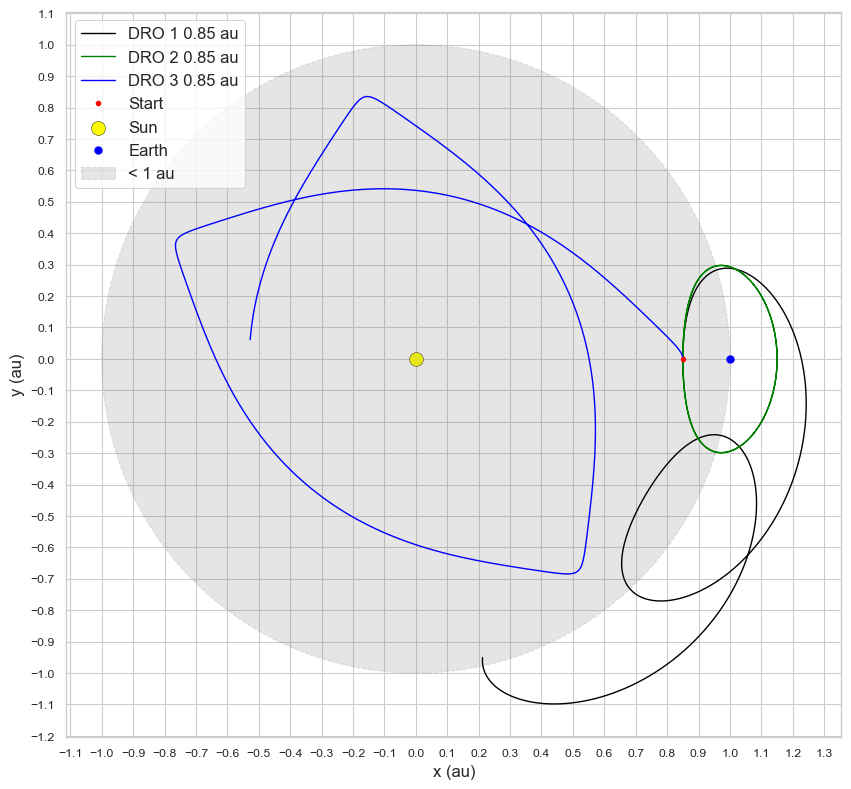

In [34]:
###################### find dro solutions by trial and error

#list for initial conditions
initial_x0_array=[]
initial_vy_array=[]

########### solution for 0.95 au is manually found 3.035 km/s; check minimization, Method 1 not quite right for the 0.95 au case
x0 = 0.85*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
#vy0 =  3.0494 # km/s  this solution is not exact for 2 orbits
vy0 =  10 # km/s  9.3298
[x1,y1]=make_dro([x0, y0, vx0, vy0],2)
initial_x0_array.append(x0/au)
initial_vy_array.append(vy0)



########### s
x0 = 0.85*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 9.3298 # km/s

[x2,y2]=make_dro([x0, y0, vx0, vy0],2)
initial_x0_array.append(x0/au)
initial_vy_array.append(vy0)



########### s
x0 = 0.85*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 3 # km/s

[x5,y5]=make_dro([x0, y0, vx0, vy0],2)
initial_x0_array.append(x0/au)
initial_vy_array.append(vy0)


print(initial_x0_array)
print(initial_vy_array)


print('done')

############# conversion for polar plot
dro_x1=x1
dro_y1=y1
dro_r1= np.sqrt(dro_x1**2 + dro_y1**2)
dro_lon1 = np.arctan2(dro_y1, dro_x1)

dro_x2=x2
dro_y2=y2
dro_r2= np.sqrt(dro_x2**2 + dro_y2**2)
dro_lon5 = np.arctan2(dro_y2, dro_x2)


dro_x5=x5
dro_y5=y5
dro_r5= np.sqrt(dro_x5**2 + dro_y5**2)
dro_lon5 = np.arctan2(dro_y5, dro_x5)


print('done')

############## quick visual check that the sim worked

sns.set_style('whitegrid')
sns.set_context('paper')   
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

#third body
ax.plot(x1, y1, 'black', linewidth=1, alpha=1.0, label='DRO 1 0.85 au')
ax.plot(x2, y2, 'green', linewidth=1, alpha=1.0, label='DRO 2 0.85 au')
#ax.plot(x3, y3, 'blue', linewidth=1, alpha=1.0, label='DRO 3 0.85 au')
#ax.plot(x4, y4, 'green', linewidth=1, alpha=1.0, label='DRO 4 0.80 au')
ax.plot(x5, y5, 'blue', linewidth=1, alpha=1.0, label='DRO 3 0.85 au')



ax.plot(x0/au, y0/au, 'o', color='red', markersize=3, label='Start', zorder=4)

# Plot Sun - fixed at origin shifted by -mu*R
sun_x = -mu  
ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3, label='Sun')
# Plot Earth - fixed at (1-mu)
earth_x = (1 - mu) 
ax.plot(earth_x, 0, 'o', color='blue', markersize=5, label='Earth', zorder=5)


# Add distance circles for reference
circle = plt.Circle((sun_x, 0), 1, fill=True, color='gray', linestyle='--', alpha=0.2, label='< 1 au')
#circle = plt.Circle((sun_x, 0), 0.72, fill=False, color='gold', linestyle='--', alpha=0.8, label='Venus orbit radius')


ax.add_patch(circle)
# Formatting
ax.set_xlabel('x (au)', fontsize=12)
ax.set_ylabel('y (au)', fontsize=12)
#ax.set_title(f'Circular Restricted 3-Body Problem: Sun-Earth System\n(Rotating Reference Frame, {days} days simulation)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=12)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.grid(True, alpha=1.0, linestyle='-')
ax.set_aspect('equal')



#### Method 1: match start and end point after 1 orbital period


In [14]:
########### start with subsolar distance of the DRO you want to find
x0 = 0.90*au  # km (between Sun and Earth)
y0 = 0
vx0 = 0

#array of initial speed in y direction
#resolution=5000 
resolution=500 

#retrograde orbits start with positive vy
vy0_arr=np.linspace(6.0,6.2,resolution)

#prograde check
#vy0_arr=-np.linspace(0.0,20.0,resolution)


distance=[]
#go through all orbit solutions for given vy0
for i in np.arange(0,len(vy0_arr),1):    
    [xtest,ytest]=make_dro([x0, y0, vx0, vy0_arr[i]],1)    
    distance.append(np.sqrt( (xtest[-1]-x0/au)**2+(ytest[-1])**2)) #y0 is always 0

distance=np.array(distance)

print(vy0_arr[-10:-1])

[6.19639279 6.19679359 6.19719439 6.19759519 6.19799599 6.19839679
 6.1987976  6.1991984  6.1995992 ]


indices  324
vy0 [km/s] values for all minima 6.129859719438878


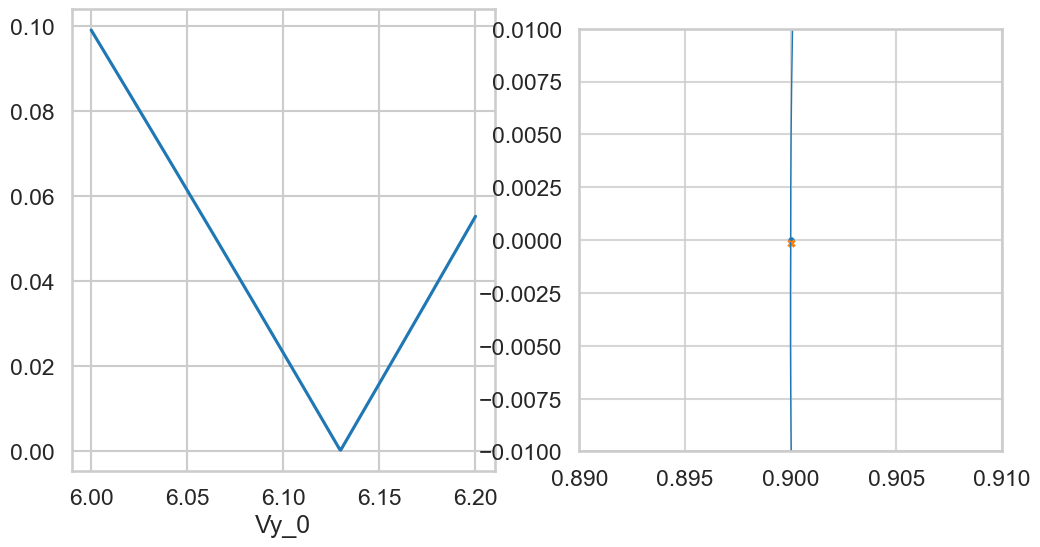

In [101]:
sns.set_style('whitegrid')
sns.set_context('talk')

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 6),dpi=100)
ax1.plot(vy0_arr,distance)  
ax1.set_xlabel('Vy_0')
#ax1.set_ylim(0,0.5)

#find all minima of distance for different orbits that close in on themselves
#for more than one minimum
#min_i = argrelextrema(distance, np.less)[0]
min_i = np.argmin(distance)
print('indices ',min_i)
print('vy0 [km/s] values for all minima',vy0_arr[min_i])

### plot all solutions that close in on themselves
#for k in np.arange(0,len(min_i)):
#    [xmini,ymini]=make_dro([x0, y0, vx0, vy0_arr[min_i[k]]],1)
#    ax2.plot(xmini,ymini,linewidth=1.0)
#    ax2.scatter(xmini[0],ymini[0],s=20,marker='o')
#   ax2.scatter(xmini[-1],ymini[-1],s=20,marker='x')

### find the absolute minimum if there is only one
[xmini,ymini]=make_dro([x0, y0, vx0, vy0_arr[min_i]],1)
ax2.plot(xmini,ymini,linewidth=1.0)
ax2.scatter(xmini[0],ymini[0],s=10,marker='o')
ax2.scatter(xmini[-1],ymini[-1],s=20,marker='x')


ax2.grid(True, alpha=0.8, linestyle='-')
ax2.set_aspect('equal')

ax2.set_xlim(x0/au-0.01,x0/au+0.01)
ax2.set_ylim(-0.01,0.01)
plt.show(fig)

### Results


**from matching start to end point after 1 orbital period (1 year)**


y0= 0.95 - > vy0 = 3.0496 km/s  # not totally right, rather should be 3.03

y0= 0.90 - > vy0 = 6.1297 km/s

y0= 0.85 - > vy0 = 9.3298 km/s

y0= 0.80 - > vy0 = 12.6525 km/s

y0= 0.75 - > vy0 = 16.1142 km/s




#### Method 2: match 2 orbital periods and minimize their shape deviation


In [ ]:

**develop: match 2 orbital periods = stability**

y0= 0.95 - > vy0 =  km/s  # 

y0= 0.90 - > vy0 = km/s

y0= 0.85 - > vy0 = km/s

y0= 0.80 - > vy0 =  km/s

y0= 0.75 - > vy0 =  km/s
